In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#raise ValueError("yo make sure this is correct and then comment me out")
# Roundabout way to access stuff in Shared With Me thru colab

# For jyang
base_dir = '/content/drive/MyDrive/FinalMLProject'

# For jwang
# base_dir = '/content/drive/.shortcut-targets-by-id/1AUovtxWcCJKisFd5mxehrPyv1LXGtJBM/FinalMLProject'

# For jpham
# Add shortcut to FinalMLProject to your drive. Then replace the long jawn with the one that matches for you by listing out file names

# List all directories (folders) in base_dir
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print("Folders in Google Drive directory:")
for folder in folders:
    print(folder)



Folders in Google Drive directory:
Machine Learning
data
all_fish
aug_data
split_data
data_split_cross


In [13]:
image_size = 224
train_dir = os.path.join(base_dir, 'aug_data/train/')
test_dir = os.path.join(base_dir, 'split_data/test/')
print("Train Dir: " + train_dir)
print("Test Dir: " + test_dir)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet18(pretrained=True)  # Load pre-trained weights
num_features = model.fc.in_features  # Get number of features in the last fully connected layer
model.fc = nn.Linear(num_features, 4)  # Replace with the 4 classes of fish
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # Loss being used is Cross Entropy
optimizer_class = torch.optim.Adam # Adam Optimizer for loss


Train Dir: /content/drive/MyDrive/FinalMLProject/aug_data/train/
Test Dir: /content/drive/MyDrive/FinalMLProject/split_data/test/
cuda


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        #Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        # Progress Bar display
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for batch_idx, (images, labels) in train_progress:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_progress.set_postfix(loss=(train_loss / (batch_idx + 1)))

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100.0 * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0

        val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (images, labels) in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                val_progress.set_postfix(loss=(val_loss / (batch_idx + 1)))

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100.0 * correct / total)

        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [15]:
from re import A
from sklearn.model_selection import KFold
import torch
import numpy as np

def k_fold_cross_validation(model, dataset, criterion, optimizer_class, k, epochs, batch_size, learning_rate, l2_lambda):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        # Split data into train and validation sets
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model.apply(reset_weights)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Train model for given fold
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, epochs
        )

        fold_metrics.append({
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accuracies[-1],
            'val_acc': val_accuracies[-1]
        })
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    # Get average metrics
    avg_metrics = {
        'train_loss': np.mean([m['train_loss'] for m in fold_metrics]),
        'val_loss': np.mean([m['val_loss'] for m in fold_metrics]),
        'train_acc': np.mean([m['train_acc'] for m in fold_metrics]),
        'val_acc': np.mean([m['val_acc'] for m in fold_metrics])
    }

    print("\nAverage Metrics Across Folds:")
    print(f"Train Loss: {avg_metrics['train_loss']:.4f}, Train Accuracy: {avg_metrics['train_acc']:.2f}%")
    print(f"Val Loss: {avg_metrics['val_loss']:.4f}, Val Accuracy: {avg_metrics['val_acc']:.2f}%")

    return avg_metrics, all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies


def reset_weights(layer):
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


In [16]:
batch_size = 32
epochs = 10
k = 5
learning_rate = 0.00025
l2_lambda=1e-4

avg_metrics, all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies = k_fold_cross_validation(model, dataset, criterion, optimizer_class, k, epochs, batch_size, learning_rate, l2_lambda)

Fold 1/5
Epoch 1/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.25it/s, loss=0.446]


Train Loss: 0.8242, Train Acc: 69.63%, Val Loss: 0.4462, Val Acc: 83.82%
Epoch 2/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.779]


Train Loss: 0.4683, Train Acc: 84.19%, Val Loss: 0.7793, Val Acc: 72.35%
Epoch 3/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.386]


Train Loss: 0.3406, Train Acc: 87.65%, Val Loss: 0.3857, Val Acc: 87.35%
Epoch 4/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  2.98it/s, loss=1.05]


Train Loss: 0.3000, Train Acc: 89.49%, Val Loss: 1.0545, Val Acc: 66.76%
Epoch 5/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.466]


Train Loss: 0.2972, Train Acc: 89.93%, Val Loss: 0.4663, Val Acc: 82.65%
Epoch 6/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.73it/s, loss=0.294]


Train Loss: 0.1844, Train Acc: 93.46%, Val Loss: 0.2940, Val Acc: 90.59%
Epoch 7/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s, loss=0.493]


Train Loss: 0.2138, Train Acc: 93.01%, Val Loss: 0.4933, Val Acc: 84.71%
Epoch 8/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.646]


Train Loss: 0.1955, Train Acc: 93.53%, Val Loss: 0.6459, Val Acc: 78.82%
Epoch 9/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s, loss=0.178]


Train Loss: 0.1365, Train Acc: 95.22%, Val Loss: 0.1776, Val Acc: 93.53%
Epoch 10/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.06it/s, loss=0.326]


Train Loss: 0.1285, Train Acc: 94.63%, Val Loss: 0.3261, Val Acc: 87.35%
Fold 2/5
Epoch 1/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.474]


Train Loss: 0.8464, Train Acc: 71.03%, Val Loss: 0.4743, Val Acc: 85.29%
Epoch 2/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s, loss=0.527]


Train Loss: 0.4616, Train Acc: 85.66%, Val Loss: 0.5270, Val Acc: 79.12%
Epoch 3/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.40it/s, loss=0.589]


Train Loss: 0.3324, Train Acc: 87.94%, Val Loss: 0.5886, Val Acc: 78.82%
Epoch 4/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.438]


Train Loss: 0.3620, Train Acc: 87.28%, Val Loss: 0.4377, Val Acc: 85.00%
Epoch 5/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.77it/s, loss=0.276]


Train Loss: 0.2799, Train Acc: 90.66%, Val Loss: 0.2761, Val Acc: 91.76%
Epoch 6/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s, loss=0.265]


Train Loss: 0.2070, Train Acc: 92.21%, Val Loss: 0.2651, Val Acc: 90.00%
Epoch 7/10


Validation: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s, loss=0.189]


Train Loss: 0.1484, Train Acc: 95.44%, Val Loss: 0.1885, Val Acc: 93.24%
Epoch 8/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s, loss=1.06]


Train Loss: 0.1076, Train Acc: 96.18%, Val Loss: 1.0613, Val Acc: 70.00%
Epoch 9/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=0.555]


Train Loss: 0.1803, Train Acc: 93.38%, Val Loss: 0.5554, Val Acc: 83.24%
Epoch 10/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  2.99it/s, loss=0.742]


Train Loss: 0.1487, Train Acc: 94.63%, Val Loss: 0.7418, Val Acc: 75.59%
Fold 3/5
Epoch 1/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.87it/s, loss=1.21]


Train Loss: 0.7831, Train Acc: 70.15%, Val Loss: 1.2097, Val Acc: 66.18%
Epoch 2/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.89it/s, loss=0.314]


Train Loss: 0.4482, Train Acc: 85.37%, Val Loss: 0.3135, Val Acc: 89.12%
Epoch 3/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s, loss=0.405]


Train Loss: 0.3285, Train Acc: 87.72%, Val Loss: 0.4049, Val Acc: 87.06%
Epoch 4/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.82it/s, loss=0.257]


Train Loss: 0.3393, Train Acc: 88.01%, Val Loss: 0.2566, Val Acc: 90.88%
Epoch 5/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=0.182]


Train Loss: 0.2864, Train Acc: 90.15%, Val Loss: 0.1822, Val Acc: 93.24%
Epoch 6/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.42it/s, loss=0.973]


Train Loss: 0.1942, Train Acc: 92.13%, Val Loss: 0.9731, Val Acc: 65.29%
Epoch 7/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.51it/s, loss=0.631]


Train Loss: 0.1475, Train Acc: 94.85%, Val Loss: 0.6312, Val Acc: 72.65%
Epoch 8/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.65it/s, loss=0.291]


Train Loss: 0.1435, Train Acc: 95.07%, Val Loss: 0.2906, Val Acc: 89.41%
Epoch 9/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.75it/s, loss=0.188]


Train Loss: 0.1419, Train Acc: 95.00%, Val Loss: 0.1878, Val Acc: 95.29%
Epoch 10/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.29it/s, loss=0.573]


Train Loss: 0.0844, Train Acc: 97.57%, Val Loss: 0.5734, Val Acc: 78.24%
Fold 4/5
Epoch 1/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.85it/s, loss=1.73]


Train Loss: 0.7646, Train Acc: 70.88%, Val Loss: 1.7285, Val Acc: 55.88%
Epoch 2/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.84it/s, loss=1.09]


Train Loss: 0.4256, Train Acc: 83.53%, Val Loss: 1.0859, Val Acc: 62.35%
Epoch 3/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.00it/s, loss=0.543]


Train Loss: 0.3263, Train Acc: 88.97%, Val Loss: 0.5426, Val Acc: 81.76%
Epoch 4/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.90it/s, loss=2.2]


Train Loss: 0.2599, Train Acc: 90.59%, Val Loss: 2.1970, Val Acc: 53.53%
Epoch 5/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.83it/s, loss=0.851]


Train Loss: 0.2438, Train Acc: 91.10%, Val Loss: 0.8508, Val Acc: 72.94%
Epoch 6/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s, loss=0.404]


Train Loss: 0.2083, Train Acc: 92.57%, Val Loss: 0.4041, Val Acc: 86.18%
Epoch 7/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.56it/s, loss=1.23]


Train Loss: 0.1523, Train Acc: 95.29%, Val Loss: 1.2341, Val Acc: 68.53%
Epoch 8/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.81it/s, loss=0.439]


Train Loss: 0.1116, Train Acc: 96.54%, Val Loss: 0.4389, Val Acc: 83.82%
Epoch 9/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s, loss=0.172]


Train Loss: 0.1064, Train Acc: 96.03%, Val Loss: 0.1717, Val Acc: 94.71%
Epoch 10/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.50it/s, loss=0.128]


Train Loss: 0.0755, Train Acc: 96.76%, Val Loss: 0.1283, Val Acc: 95.00%
Fold 5/5
Epoch 1/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.764]


Train Loss: 0.7599, Train Acc: 71.76%, Val Loss: 0.7640, Val Acc: 70.59%
Epoch 2/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.51it/s, loss=0.639]


Train Loss: 0.5183, Train Acc: 80.88%, Val Loss: 0.6390, Val Acc: 77.94%
Epoch 3/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.34it/s, loss=0.498]


Train Loss: 0.3393, Train Acc: 88.24%, Val Loss: 0.4981, Val Acc: 81.18%
Epoch 4/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=0.344]


Train Loss: 0.2974, Train Acc: 89.78%, Val Loss: 0.3436, Val Acc: 87.06%
Epoch 5/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.70it/s, loss=1.44]


Train Loss: 0.2374, Train Acc: 92.21%, Val Loss: 1.4413, Val Acc: 62.65%
Epoch 6/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  3.12it/s, loss=0.241]


Train Loss: 0.1808, Train Acc: 93.60%, Val Loss: 0.2408, Val Acc: 89.71%
Epoch 7/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s, loss=0.397]


Train Loss: 0.1687, Train Acc: 93.75%, Val Loss: 0.3965, Val Acc: 85.00%
Epoch 8/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.79it/s, loss=1.23]


Train Loss: 0.1728, Train Acc: 93.46%, Val Loss: 1.2323, Val Acc: 68.82%
Epoch 9/10


Validation: 100%|██████████| 11/11 [00:03<00:00,  2.92it/s, loss=0.236]


Train Loss: 0.1968, Train Acc: 93.01%, Val Loss: 0.2359, Val Acc: 90.88%
Epoch 10/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  3.86it/s, loss=0.21]

Train Loss: 0.0975, Train Acc: 96.91%, Val Loss: 0.2100, Val Acc: 90.29%

Average Metrics Across Folds:
Train Loss: 0.1069, Train Accuracy: 96.10%
Val Loss: 0.3959, Val Accuracy: 85.29%


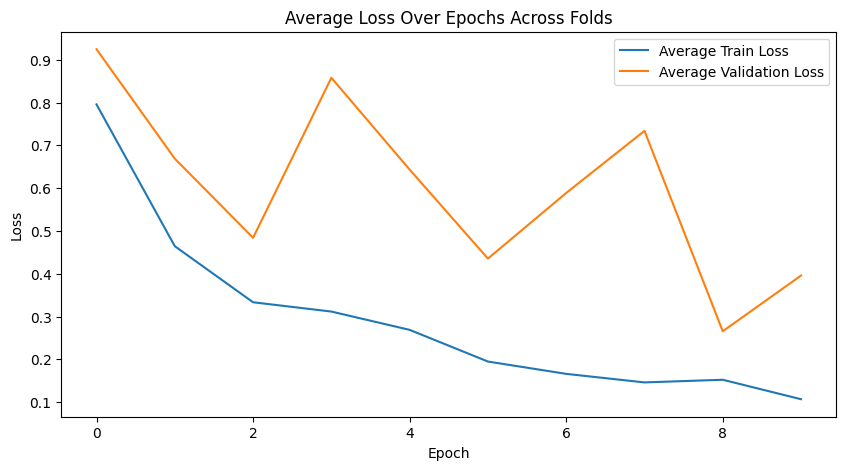

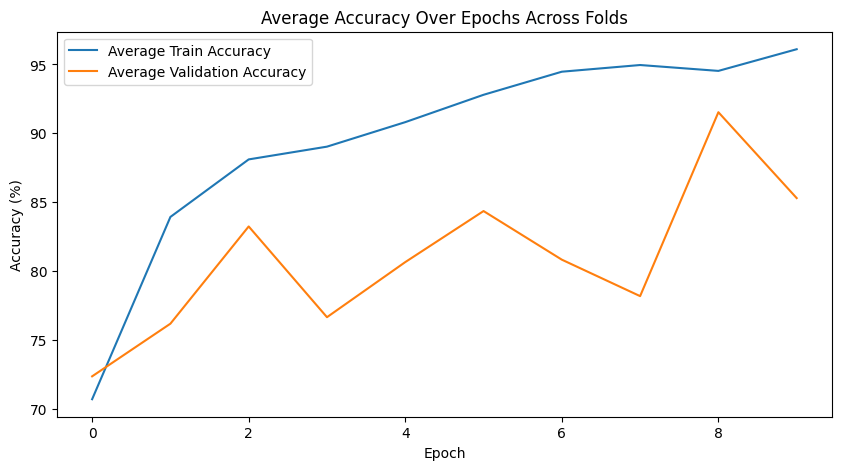

average_train_losses[0.7956349  0.46441185 0.3334181  0.31170738 0.26895388 0.19493628
 0.16615711 0.14619536 0.15238508 0.10692445]
average_val_losses[0.92454087 0.66892201 0.48397274 0.85787713 0.64334296 0.43542723
 0.58872516 0.73381747 0.26565986 0.39590298]
average_train_accuracies[70.69117647 83.92647059 88.10294118 89.02941176 90.80882353 92.79411765
 94.47058824 94.95588235 94.52941176 96.10294118]
average_val_accuracies[72.35294118 76.17647059 83.23529412 76.64705882 80.64705882 84.35294118
 80.82352941 78.17647059 91.52941176 85.29411765]


In [17]:
# Calculate average metrics across folds
average_train_losses = np.mean(all_train_losses, axis=0)  # Average loss per epoch
average_val_losses = np.mean(all_val_losses, axis=0)
average_train_accuracies = np.mean(all_train_accuracies, axis=0)
average_val_accuracies = np.mean(all_val_accuracies, axis=0)

# Plot Average Loss
plt.figure(figsize=(10, 5))
plt.plot(average_train_losses, label="Average Train Loss")
plt.plot(average_val_losses, label="Average Validation Loss")
plt.title("Average Loss Over Epochs Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Average Accuracy
plt.figure(figsize=(10, 5))
plt.plot(average_train_accuracies, label="Average Train Accuracy")
plt.plot(average_val_accuracies, label="Average Validation Accuracy")
plt.title("Average Accuracy Over Epochs Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

print('average_train_losses' + str(average_train_losses))
print("average_val_losses" + str(average_val_losses))
print("average_train_accuracies" + str(average_train_accuracies))
print("average_val_accuracies" + str(average_val_accuracies))

In [18]:
import warnings
def display_test_predictions(model, test_loader, class_names, num_images=16):

    model.eval()
    model = model.to(device)
    images_shown = 0
    correct_preds = 0
    total_preds = 0
    fig = plt.figure(figsize=(6, 6))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                #Unnormalize the image
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

                ax = fig.add_subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), images_shown + 1, xticks=[], yticks=[])
                ax.imshow(img)
                ax.set_title(f"True: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}",
                             color=("green" if preds[i] == labels[i] else "red"))
                images_shown += 1

            if images_shown >= num_images:
                break

    accuracy = 100 * correct_preds / total_preds
    warnings.filterwarnings("ignore")

    plt.tight_layout()
    plt.show()
    print(f"Test Accuracy: {accuracy:.2f}%")



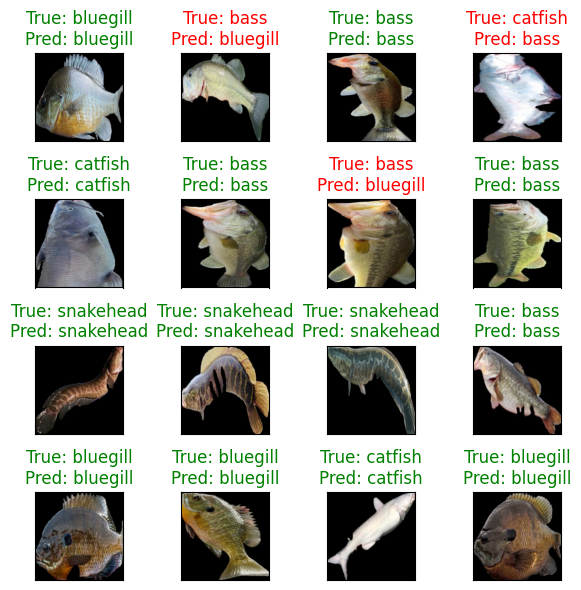

Test Accuracy: 78.12%


In [25]:

# Display a sample of the test dataset, the correctness of the prediction and test accuracy
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

display_test_predictions(model, test_loader, class_names=['bass', 'bluegill', 'catfish', 'snakehead'])